In [33]:
import pandas as pd
import random
from tqdm import tqdm
import numpy as np

from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('./Data/Online_Retail.xlsx')

In [4]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
print("The dataset contains %d transactions. And its a good amount of data to train our model" %df.shape[0])

The dataset contains 541909 transactions. And its a good amount of data to train our model


In [7]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.StockCode = df.StockCode.astype(str)

In [13]:
customers = df.CustomerID.unique()
print("The Dataset contains %d unique customers" %len(customers))

The Dataset contains 4372 unique customers


In [19]:
random.shuffle(customers)

customers_train = [customers[i] for i in range(int(0.9*len(customers)))]

train_df = df[df.CustomerID.isin(customers_train)]
validation_df = df[~df.CustomerID.isin(customers_train)]

In [31]:
purchases_train = []


for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)



  0%|          | 0/3934 [00:00<?, ?it/s]

  2%|▏         | 73/3934 [00:00<00:05, 726.00it/s]

  4%|▍         | 152/3934 [00:00<00:05, 742.91it/s]

  6%|▌         | 232/3934 [00:00<00:04, 757.05it/s]

  8%|▊         | 311/3934 [00:00<00:04, 764.13it/s]

 10%|▉         | 389/3934 [00:00<00:04, 767.98it/s]

 12%|█▏        | 469/3934 [00:00<00:04, 774.78it/s]

 14%|█▍        | 548/3934 [00:00<00:04, 776.74it/s]

 16%|█▌        | 628/3934 [00:00<00:04, 783.48it/s]

 18%|█▊        | 707/3934 [00:00<00:04, 785.18it/s]

 20%|██        | 787/3934 [00:01<00:03, 787.10it/s]

 22%|██▏       | 864/3934 [00:01<00:03, 777.99it/s]

 24%|██▍       | 941/3934 [00:01<00:04, 723.73it/s]

 26%|██▌       | 1014/3934 [00:01<00:04, 688.47it/s]

 28%|██▊       | 1084/3934 [00:01<00:04, 673.33it/s]

 30%|██▉       | 1163/3934 [00:01<00:03, 703.63it/s]

 31%|███▏      | 1234/3934 [00:01<00:03, 681.21it/s]

 33%|███▎      | 1303/3934 [00:01<00:03, 667.18it/s]

 35%|███▍      | 1371/3934 [00:01<00:03, 647.15it/s

In [26]:
purchases_val = []

for i in tqdm(validation_df.CustomerID.unique()):
    print()
    temp = validation_df[validation_df.CustomerID == i].StockCode.tolist()
    purchases_val.append(temp)

100%|██████████| 438/438 [00:00<00:00, 1259.83it/s]


In [37]:
model = Word2Vec(window = 10, sg = 1, hs =0,
                negative = 10, 
                alpha = 0.03, min_alpha=0.0007,
                seed=14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples=model.corpus_count,
           epochs=10, report_delay=1)

(3595584, 3633050)

In [38]:
model.init_sims(replace=True)

In [39]:
print(model)

Word2Vec(vocab=3174, size=100, alpha=0.03)


In [40]:
X = model[model.wv.vocab]

X.shape

(3174, 100)

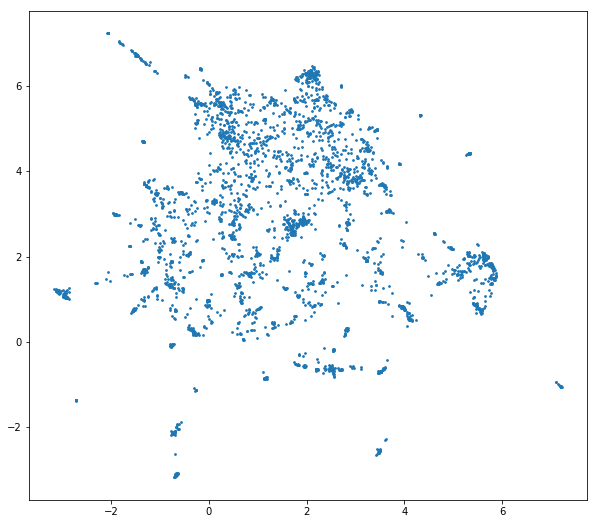

In [43]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [45]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [46]:
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [47]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms   

In [48]:
similar_products(model['90019A'])

[('SILVER M.O.P ORBIT DROP EARRINGS', 0.8122975826263428),
 ('JADE DROP EARRINGS W FILIGREE', 0.7800703644752502),
 ('GOLD/M.O.P PENDANT ORBIT NECKLACE', 0.7736604809761047),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.7625695466995239),
 ('BLUE MURANO TWIST BRACELET', 0.7519446611404419),
 ('ANT COPPER RED BOUDICCA BRACELET', 0.7512853741645813)]